# Proyecto 04 - Procesamiento del Lenguaje Natural

## Dataset: Women's E-Commerce Clothing Reviews

**El dataset se puede descargar [aquí](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews).  La licencia corresponde a [CC0](https://creativecommons.org/publicdomain/zero/1.0/).**

### Exploración de datos y Procesamiento del Lenguaje Natural

Este dataset tiene una gran variedad de caminos que se pueden explorar y muchas preguntas por responder. Lo que se buscará abordar en este proyecto es predecir si una prenda será recomendada por su compradora o no, reduciendo el problema a una clasificación binaria: "recomendada" y "no recomendada".

Se explorarán los datos para concer qué variables están fuertemente correlacionadas y pueden servir para predecir lo previamente expuesto.

### Motivación
Una buena estrategia de marketing es la publicidad que hacen los clientes satisfechos, ya que garantizan entre sus conocidos que el producto es bueno. Por tanto, se considera como una motivación para este proyecto tratar de predecir si un cliente recomendará un producto a potenciales nuevos clientes.

No es relevante la puntuación que le da por sí misma, sino en cuanto nos permite conocer, junto a otras variables, si ese producto fue lo suficientemente bueno para el usuario que éste lo recomiende a otros.

### Objetivo del Proyecto
Implementar un modelo para predecir si un usuario recomendará una prenda a partir de su reseña y otros atributos.

### Desarrollo
- Link al repositorio de GitHub con la resolución completa: <https://github.com/lusalmeron/Acamica-DS-Proyecto-4>

### Referencia
- Link al repositorio de GitHub con el Prpoyecto 3 de NLP: <https://github.com/lusalmeron/Acamica-DS-Proyecto-3-NLP>

En el Proyecto 3 dejé planteado el uso de bigramas para investigar si mejora el desempeño del modelo. Esto mismo es lo que implementaré en la parte de ntrenamiento.

## Importamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Garbage collector para optimizar recursos
import gc

# Clase para personalizar las impresiones de consola
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#### Importamos librerías SpaCy y NLTK

Para el tratamiento de texto, las librerías que nos brindan las herramientas adecuadas son **SpaCy** y **NLTK**. Dependiendo de lo que se quiera hacer, utilizaremos una o la otra.

In [2]:
# Previamente
## python -m spacy download en_core_web_md
import spacy # https://spacy.io/usage/models
nlp = spacy.load('en_core_web_md')

#Stop Words de en_core_news_md
from spacy.lang.en.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

In [3]:
import nltk

#Stop Words de nltk
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('english'))

# Quitamos de las stopwords la palabra 'no', que nos puede ser últil para predecir
#stopwords_nltk.remove('no')

In [4]:
# Para manejo de resgitros de texto
import re
from nltk.tokenize import RegexpTokenizer

#Constante de signos de puntuación
import string
puntua = string.punctuation + '#...'
excluded_pos = ['SCONJ','CCONJ','NUM','PUNCT','PRON','DET','ADP','AUX','X','PROPN']

## Importamos el dataset

In [3]:
df = pd.read_csv("data/Womens_Clothing_Reviews.csv")
print("- Cantidad de filas del set:" + color.YELLOW, df.shape[0],color.END)
print("- Cantidad de atributos (columnas) del dataset:" + color.CYAN, df.shape[1],color.END)

- Cantidad de filas del set: 23486 
- Cantidad de atributos (columnas) del dataset: 11 


Exploramos el dataset para entender los datos:

In [4]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
df.tail()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses
23485,23485,1104,52,Please make more like this one!,This dress in a lovely platinum is feminine an...,5,1,22,General Petite,Dresses,Dresses


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [7]:
# Porcentaje de nulos por columna
df.isna().sum()*100/df.shape[0]

Unnamed: 0                  0.000000
Clothing ID                 0.000000
Age                         0.000000
Title                      16.222430
Review Text                 3.597888
Rating                      0.000000
Recommended IND             0.000000
Positive Feedback Count     0.000000
Division Name               0.059610
Department Name             0.059610
Class Name                  0.059610
dtype: float64

#### Transformaciones

In [8]:
# Descartamos columna de índice 'Unnamed'
df.drop(columns=['Unnamed: 0'], inplace=True)
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [9]:
# Renombramos las columnas para que sean más descriptivas
mapper = {'Clothing ID':'clothing_id', 'Age':'usr_age', 'Title':'review_title', 'Review Text':'review_body', 'Rating':'rating',
       'Recommended IND':'recommended', 'Positive Feedback Count':'pos_feedback_count', 'Division Name':'div_name',
       'Department Name':'dept_name', 'Class Name':'class_name'}
df.rename(columns=mapper,inplace=True)
df.columns

Index(['clothing_id', 'usr_age', 'review_title', 'review_body', 'rating',
       'recommended', 'pos_feedback_count', 'div_name', 'dept_name',
       'class_name'],
      dtype='object')

In [21]:
# Rellenar títulos vacíos y quitar filas con nulos
print(df.shape[0])
data  = df.copy()
data.fillna(value={'review_title':"-"}, inplace=True)
data = data.dropna()
data.reset_index(drop=True, inplace=True)
print(df.shape[0])

23486
22628


In [22]:
# Hay reviews con caracteres decodificados
## &quot; == "
## &#39; == '
## &amp;quot;
## &amp;#39; == ´
## &amp;amp;#39;
## &amp;amp;amp;#39; == ´
## &amp;amp;amp;amp;#39; == '' 
## &amp;amp;amp;amp;quot; == '
import string
idxs = data[data.review_body.str.contains('&amp;#39;')].index
#idxs = data[data.review_body.str.find('&amp') != -1].index
for idx in idxs:
    print(idx,' - ',data.review_body.iloc[idx],'\n')

256  -  Love the look and quality of this jacket. i&amp;#39;d say it fits true to size but it is way too short for me (i&amp;#39;m just under 6&amp;#39; tall). wish these came in tall sizes! 

484  -  Is not a place i want to be, even if the style of a sweater is great.  yes, this sweater is very cropped, but i think it&amp;#39;s definitely intended to be worn off the shoulder to drop the waist a bit.  it&amp;#39;s the itchiness that makes it an immediate &amp;quot;no&amp;quot;, and that&amp;#39;s coming from someone who has serious fiber itch tolerance. 

2420  -  Very comfortable to wear. you can wear it any season.  it runs true to size.  nice fabric.  it&amp;#39;s a simple black dress.  love it! 

9506  -  I am pretty standard size 8, 36c, 5&amp;#39;6&amp;quot;, 150 lbs. i ordered the small and the bust fit well but the whole thing was like a tent and way too flowy for my taste. it was also long so everything was very covered. i didn&amp;#39;t feel it flattered my build. i returned

In [23]:
# Reemplazo de caracteres en formato ilegible
data.replace(to_replace=None, regex={
    '^.*&quot;.*$':'"',
    "^.*&#39;.*$":"'",
    "^.*&amp;quot;.*$":'´"',
    "^.*&amp;#39;.*$":"''",
    "^.*&amp;amp;amp;.*$":"&",
    "^.*&amp;amp;#39;.*$":"''",
    "^.*&amp;amp;amp;#39;.*$":"´´",
    "^.*&amp;amp;amp;amp;#39;.*$":"''",
    "^.*&amp;amp;amp;amp;quot;.*$":'´"'
},inplace=True)

## Análisis Exploratorio de Datos
#### Algunas preguntas que van surgiendo...
#### 1. ¿Qué clases de productos hay en el dataset?

In [60]:
data.class_name.value_counts()

Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1104
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               332
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Chemises             1
Casual bottoms       1
Name: class_name, dtype: int64

#### 2. ¿Cuántas reseñas hay por cada valoración (1-5) según la categoría?

In [61]:
data_grouped = data.clothing_id.groupby([data['class_name'],data['rating']]).count().astype(int).reset_index(name='count')
data_grouped

,class_name,rating,count
0,Blouses,1,115
1,Blouses,2,228
2,Blouses,3,384
3,Blouses,4,645
4,Blouses,5,1611
...,...,...,...
87,Trend,1,10
88,Trend,2,11
89,Trend,3,19
90,Trend,4,26


##### Visualización

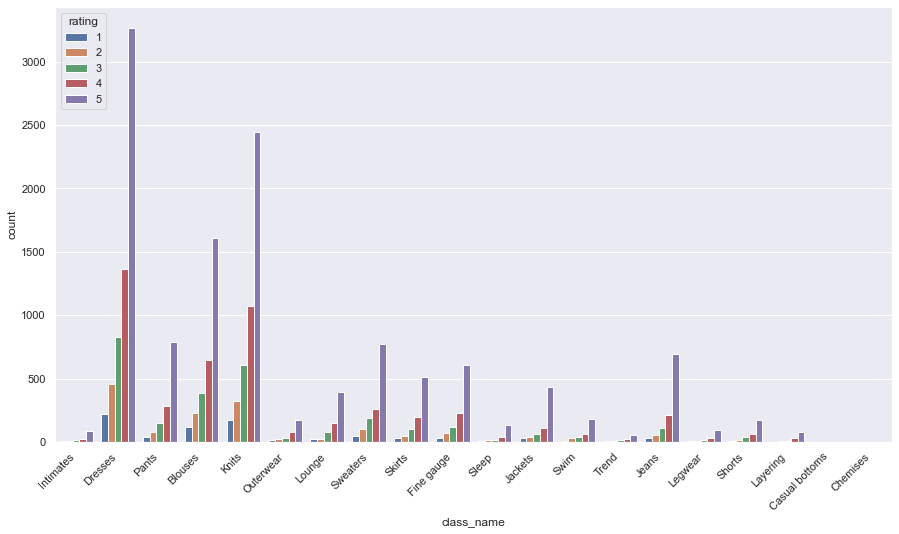

In [62]:
# Visualización
plt.figure(figsize=(15,8))
grafico = sns.countplot(x=data['class_name'],data=data, hue='rating')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 3. ¿Cuál es el promedio de rating por cada clase? <br>
*La media debería dar alrededor de 3, pero aquellos que estén por debajo significa que fueron en su mayoría peor calificados. Inversamente sucede con los que están por encima de 3, lo que significa que fueron en su mayoría muy bien calificados.*

In [63]:
# Promedio de estrellas por categoría ordenados de forma ascendente
from statistics import mean
data_grouped = data.rating.groupby([data['class_name']]).mean().reset_index(name='avg_rating')
data_grouped['rev_count'] = data.rating.groupby([data['class_name']]).count().astype(int).reset_index(name='rev_count').rev_count
data_grouped.sort_values(by='avg_rating',ascending=False, inplace=True)
data_grouped.reset_index(inplace=True,drop=True)
data_grouped

,class_name,avg_rating,rev_count
0,Layering,4.348485,132
1,Jeans,4.347826,1104
2,Lounge,4.301943,669
3,Sleep,4.294393,214
4,Jackets,4.288433,683
5,Intimates,4.278912,147
6,Pants,4.261481,1350
7,Shorts,4.253289,304
8,Legwear,4.246835,158
9,Fine gauge,4.237960,1059


##### Visualización

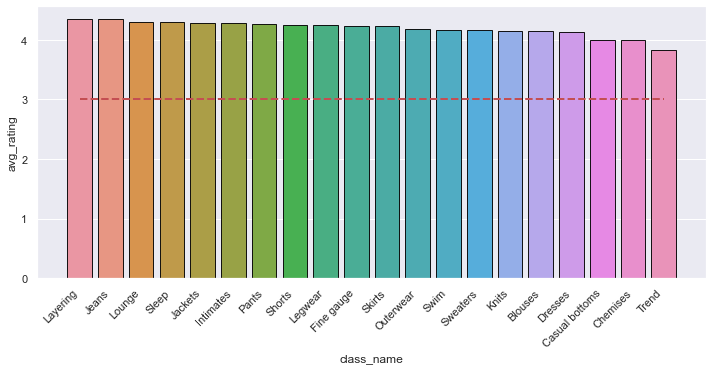

In [64]:
# Visualización de valoración promedio por categoría
data_grouped.sort_values(['avg_rating','rev_count'],ascending=False,inplace=True)
cte = np.ones(data_grouped.shape[0])*3 # Valor medio
plt.figure(figsize=(12,5))
grafico = sns.barplot(x=data_grouped.class_name, y=data_grouped.avg_rating, linewidth=0.9,edgecolor=(0,0,0))
plt.plot(cte, ls = '--', lw = 2, c='r',label = 'Valoración media')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 4. ¿Cuántas reseñas hay por cada clase? <br>
*Esto nos permitirá dar contexto a los promedios previamente obtenidos.*

<AxesSubplot:title={'center':'Cantidad de reviews por clase'}, xlabel='Clase', ylabel='Cantidad de reseñas'>

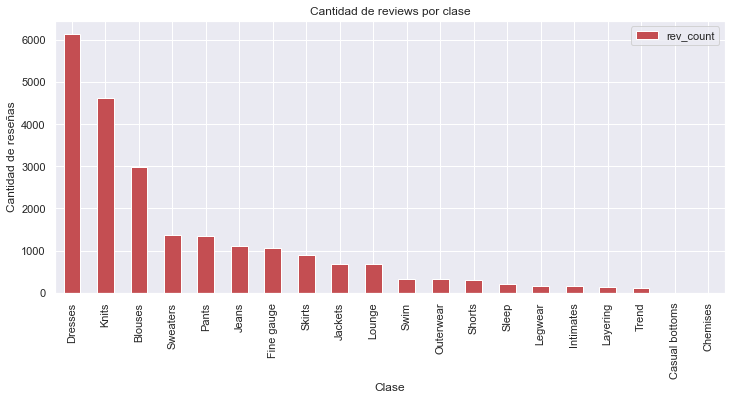

In [65]:
data_grouped.sort_values(by='rev_count',ascending=False).plot(x='class_name',y='rev_count',kind='bar',figsize=(12,5),title='Cantidad de reviews por clase', xlabel='Clase', ylabel='Cantidad de reseñas', color= 'r')

*Aquí se ve que, aunque `Layering` es la que tiene mayor promedio, es una de las últimas en cantidad de reseñas. Por otro lado, `Dresses`, que aún siendo alto es uno de los promedios más bajos, es la que tiene la máxima cantidad de reseñas.*

#### 5. ¿Cuántas reviews hay por cada rating?

In [66]:
data.rating.value_counts()

5    12527
4     4908
3     2823
2     1549
1      821
Name: rating, dtype: int64

*Vemos que no está equilibrado por cada valoración posible. Hay 15 veces más ratings de 5 que 1.*

#### 6. ¿Cuántas reseñas son de prendas recomendadas? 

In [67]:
data_recom = data.clothing_id.groupby([data['class_name'],data['recommended']]).count().astype(int).reset_index(name='count')
data_recom

,class_name,recommended,count
0,Blouses,0,577
1,Blouses,1,2406
2,Casual bottoms,1,1
3,Chemises,1,1
4,Dresses,0,1197
5,Dresses,1,4948
6,Fine gauge,0,177
7,Fine gauge,1,882
8,Intimates,0,21
9,Intimates,1,126


##### Visualización

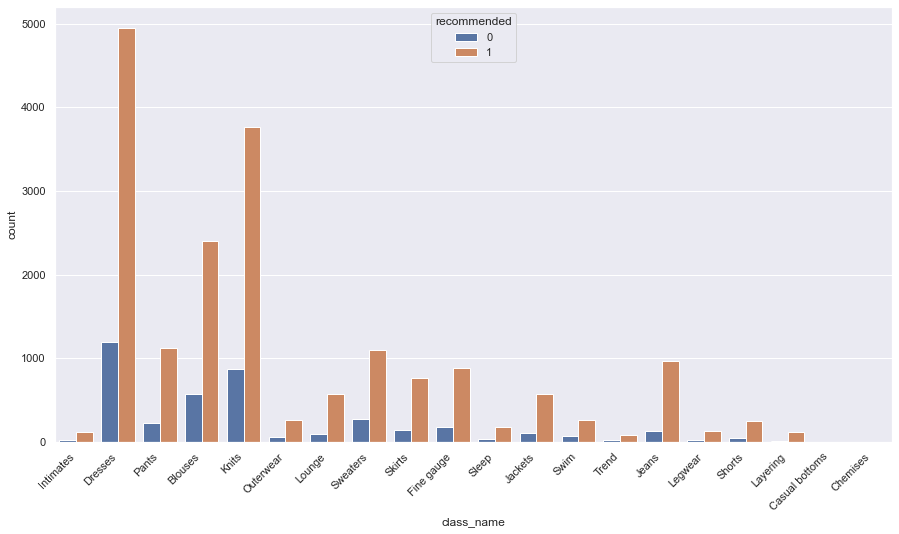

In [68]:
# Visualización
plt.figure(figsize=(15,8))
grafico = sns.countplot(x=data['class_name'],data=data, hue='recommended')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 7. ¿Cuántas reseñas hay por cada clase "recomendada"(1) "no recomendada"(0)? <br>

1    18527
0     4101
Name: recommended, dtype: int64

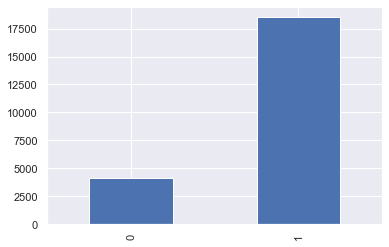

In [69]:
data.recommended.value_counts().plot(kind='bar')
data.recommended.value_counts()

#### 8. ¿Edad máxima y mínima de los usuarios que publicaron en este dataset?

In [70]:
max_age = data.usr_age.max()
print("- " + color.RED + "Máxima" + color.END + " edad:", max_age, "años")
data[data.usr_age == max_age]
#print("En total escribieron" + color.BOLD, unique_usrs, color.END + "usuarios únicos de las" + color.BOLD, data.shape[0],color.END + "reseñas existentes.")
#print("Esto equivale al" + color.CYAN, unique_usrs*100//data.shape[0], "%" + color.END)

- Máxima edad: 99 años


,clothing_id,usr_age,review_title,review_body,rating,recommended,pos_feedback_count,div_name,dept_name,class_name
8035,1078,99,Beachy and boho!,I love the weight of the material; sometimes c...,5,1,1,General,Dresses,Dresses
11137,949,99,-,"Great quality, i didn't expect the neck to be ...",4,1,4,General,Tops,Sweaters


*Es raro pensar que una persona de 99 años hizo una compra de E-Commerce. Podría ser un error.*

Vemos si hay usuarios de más de 70 años:

In [71]:
print("- Cantidad de usuarios mayores a 70 años:",data[data.usr_age >=70].shape[0])

- Cantidad de usuarios mayores a 70 años: 463


In [72]:
min_age = data.usr_age.min()
print("- " + color.BLUE + "Mínima" + color.END + " edad:", min_age, "años")
data[data.usr_age == min_age]

- Mínima edad: 18 años


,clothing_id,usr_age,review_title,review_body,rating,recommended,pos_feedback_count,div_name,dept_name,class_name
8552,1094,18,Love,I bought this dress for my engagement photo sh...,5,1,0,General,Dresses,Dresses
18997,1008,18,Stunning,This skirt is absolutely beautiful and is a go...,5,1,1,General,Bottoms,Skirts
21542,1072,18,I get so many compliments,I found this dress on sale in store and i usua...,4,1,0,General,Dresses,Dresses
21568,868,18,"A little big, but so comfortable!",This shirt is incredibly comfortable. the mate...,4,1,0,General,Tops,Knits


#### 9. ¿Cuántos productos únicos aparecen en las reseñas?

In [73]:
# Ver sobre cuántos productos únicos se publicaron reseñas
unique_prods = len(data.clothing_id.unique())
print("De las" + color.BOLD, data.shape[0],color.END + "reseñas, se mencionan" + color.BOLD, unique_prods , color.END + "productos únicos.")
print("Esto equivale al" + color.CYAN, unique_prods*100//data.shape[0], "%" + color.END)

De las 22628 reseñas, se mencionan 1172 productos únicos.
Esto equivale al 5 %


#### 10. Tomamos como ejemplo una prenda y analizamos si fue recomendada o no y su rating

In [74]:
rand_idx = np.random.randint(0,data.shape[0])
item = data.clothing_id.iloc[rand_idx]
item_data = data[data.clothing_id == item]
print("Tipo de la prenda" + color.BOLD, item,color.END + ":",  data.class_name.iloc[rand_idx])
print("Cantidad de reseñas de la prenda" + color.BOLD, item,color.END + ":", len(item_data))
print("Promedio de rating que ha recibido:" + color.YELLOW, item_data.rating.mean(),color.END)
item_data[['clothing_id','class_name','review_title','review_body','rating']].reset_index(drop = True, inplace=True)

Tipo de la prenda 639 : Lounge
Cantidad de reseñas de la prenda 639 : 1
Promedio de rating que ha recibido: 5.0 


In [75]:
print(color.BOLD + "Título:" + color.END,item_data.review_title.iloc[0])
print(color.BOLD + "Reseña:" + color.END,item_data.review_body.iloc[0])
print(color.BOLD + "Rating:" + color.END,item_data.rating.iloc[0])
if (item_data.recommended.iloc[0]):
    print(color.BOLD + "Categoría:" + color.END + "Recomendado")
else:
    print(color.BOLD + "Categoría:" + color.END + "No recomendado")

Título: -
Reseña: Luv this top/dress/coverup..runs a lil big...i sized down for a more fitted look to pair it with cropped skinny jeans! fabric is nice, comfortable and light!
Rating: 5
Categoría:Recomendado


In [58]:
df[df.review_title == "nan"]

,clothing_id,usr_age,review_title,review_body,rating,recommended,pos_feedback_count,div_name,dept_name,class_name


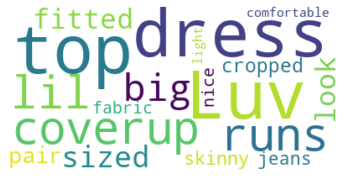

In [81]:
# pip install wordcloud --> HAY ERROR!!
from wordcloud import WordCloud
if(item_data.review_title.iloc[0] == '-'):
    wordcloud = WordCloud(background_color='white',stopwords=stopwords_nltk).generate(item_data.review_body.iloc[0])
else:
    wordcloud = WordCloud(background_color='white',stopwords=stopwords_nltk).generate(item_data.review_title.iloc[0] + ' ' + item_data.review_body.iloc[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

*Con una review a veces no es tan eficiente el Wordcloud para visualizar ya que puede no haber palabras repetidas. Buscamos entonces juntar más reviews de un mismo tipo "Recomendado" y "No recomendado"*.

#### 11. ¿Cuáles son las palabras más frecuentes por cada clase?
Para responder a esto utilizmos la librería spaCy para el procesamiento del lenguaje natural.

In [82]:
# Separamos en distintos dataframes las reviews según valoración
data_recom = data[data['recommended']==1]
data_not_recom = data[data['recommended']==0]

<span style='color:purple;'>**Empezamos analizando las reviews "Recomendadas":**</span>
<br> Vamos a quedarnos sólo con los adjetivos para mejorar la visualización. <br>(5 min)

In [83]:
todas_reviews_recom = []
for i in data_recom.index:
    review1 = data_recom.review_body[i] #seleccionar el titular
    sent = nlp(str(review1))
    for token in sent:
        if (token.pos_ == "ADJ" and token.text not in stopwords_spacy and len(token.text)>2):
            temp = token.lemma_
            todas_reviews_recom.append(temp.lower()) #agregar el resultado a la lista

print('- Cantidad de palabras filtradas:' + color.BOLD,len(todas_reviews_recom), color.END)
print('Ejemplos:')
todas_reviews_recom[:3]

- Cantidad de palabras filtradas: 116235 
Ejemplos:


['wonderful', 'silky', 'sexy']

In [84]:
# Obtenemos frecuencia de palabras y creamos nuevo df
freq_rev_recom = nltk.FreqDist(todas_reviews_recom)
df_rev_frec_recom = pd.DataFrame(freq_rev_recom.items(), columns = ['Palabra', 'Frecuencia']) 
df_rev_frec_recom.sort_values(by=['Frecuencia'], inplace=True, ascending=False)
df_rev_frec_recom.reset_index(drop = True, inplace=True)
df_rev_frec_recom.head()

,Palabra,Frecuencia
0,great,5529
1,small,3807
2,perfect,3450
3,little,3224
4,soft,3123


In [85]:
# Vemos la parte inferior
df_rev_frec_recom[df_rev_frec_recom['Frecuencia']<3]

,Palabra,Frecuencia
1117,lovely-,2
1118,checkered,2
1119,public,2
1120,overwhelmed,2
1121,enlarged,2
...,...,...
2691,washing,1
2692,shrank,1
2693,cheezy,1
2694,free-,1


##### Visualizamos la frecuencia de las palabras en las reviews "Recomendadas"

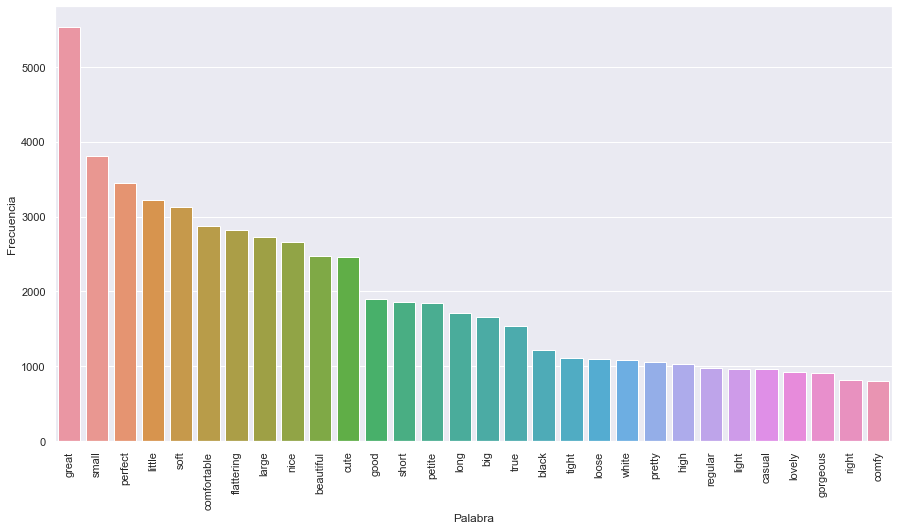

In [86]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_recom.iloc[:30].Palabra, y = df_rev_frec_recom.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [87]:
from wordcloud import WordCloud

# Definimos función para ver el wordcloud de una lista de palabras
def ver_wordcloud(palabras):
    text = ' '.join(palabras)
    wordcloud = WordCloud(background_color='white',width=900,height=450).generate(text.strip())
    plt.figure(figsize = (15,8), facecolor = None)
    plt.imshow(wordcloud, interpolation='kaiser')
    plt.axis("off")
    plt.show()

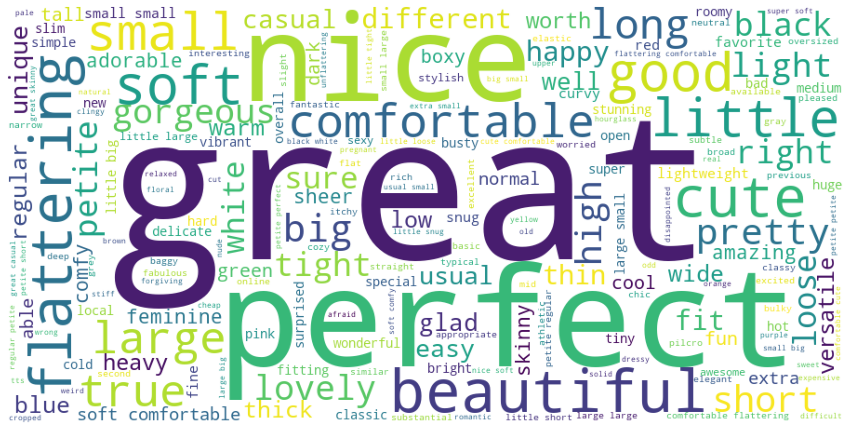

In [88]:
ver_wordcloud(todas_reviews_recom)

##### Abstracción
Para procesar los restantes dataframes, abstraemos todas las operaciones en dos funciones:

In [89]:
def adj_list(dataframe):
    todas_reviews = []
    for i in dataframe.index:
        review1 = dataframe.review_body[i] #seleccionar el titular
        sent = nlp(str(review1))
        # review1 = RegexpTokenizer('\w+').tokenize(review1) # Tokenizar con RegexpTokenizer
        for token in sent:            
            if (token.pos_ == "ADJ" and str(token) not in stopwords_spacy and len(token.text)>2):
                temp = token.lemma_
                todas_reviews.append(temp.lower()) #agregar el resultado a la lista
    return todas_reviews

def adj_frecquency_df(todas_reviews):
    # plain_todas_reviews = list(itertools.chain(*todas_reviews)) # Aplanar la lista
    freq_revs = nltk.FreqDist(todas_reviews) # Obtener frecuencia por palabra
    df_revs = pd.DataFrame(freq_revs.items(), columns = ['Palabra', 'Frecuencia']) # Crear nuevo df
    df_revs.sort_values(by=['Frecuencia'], inplace=True, ascending=False) # Ordenar valores por frecuencia
    df_revs.reset_index(drop = True, inplace=True) # Resetear index
    return df_revs

<span style='color:purple;'>**Analizamos las reviews "No recomendadas":**</span> <br>
(5 min)

In [90]:
# Listamos los adjetivos de las reviews no recomendadas
todas_reviews_not_recom = adj_list(data_not_recom)

In [91]:
df_rev_frec_not_recom = adj_frecquency_df(todas_reviews_not_recom)
df_rev_frec_not_recom

,Palabra,Frecuencia
0,small,954
1,large,639
2,short,582
3,cute,533
4,great,521
...,...,...
1432,magnificent,1
1433,ironic,1
1434,unbelievable,1
1435,xxxl,1


##### Visualizamos la frecuencia de las palabras en las reviews "No recomendadas"

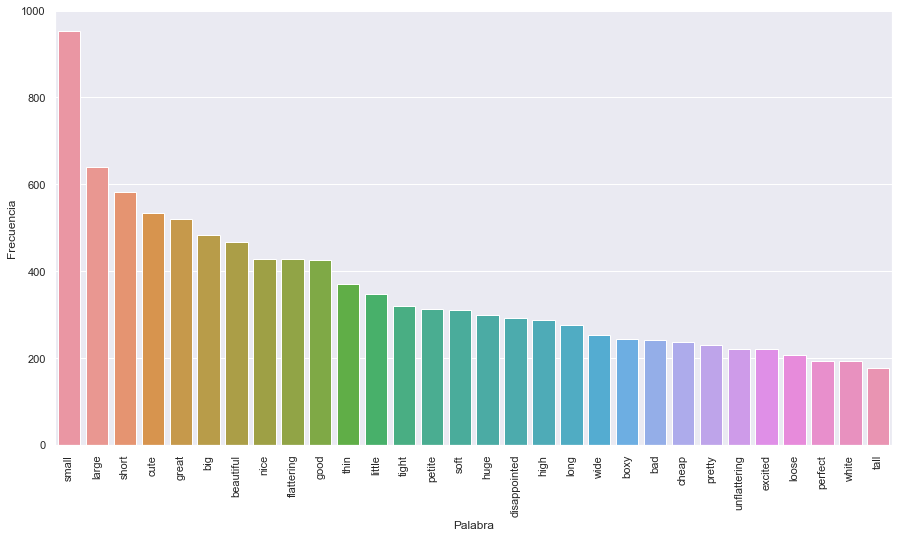

In [92]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_not_recom.iloc[:30].Palabra, y = df_rev_frec_not_recom.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

*Palabras como 'great', 'cute' y 'beautiful' se repiten con las recomendadas pero tienen connotación negativa o deben estar acompañadas de una negación*.

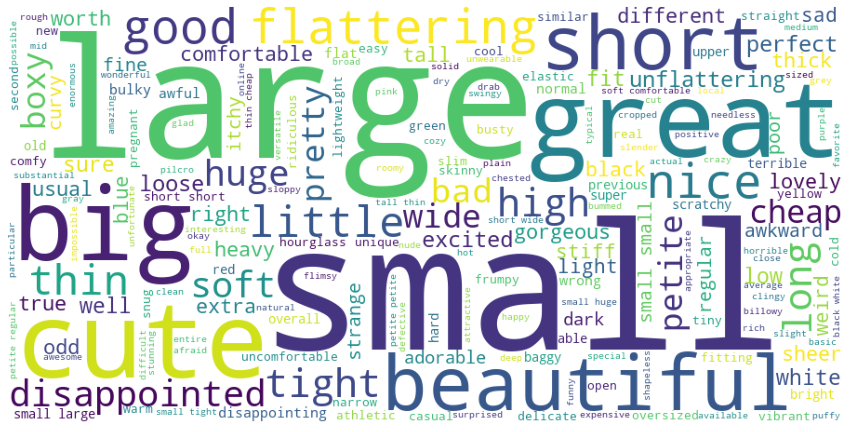

In [93]:
ver_wordcloud(todas_reviews_not_recom)

#### 12. ¿Qué palaras hacen la diferencia en las reseñas que son neutrales (rating = 3) y no recomiendan la prenda?

In [94]:
# Listamos los adjetivos de las reviews no recomendadas
reviews_3_not_recom = adj_list(data_not_recom[data_not_recom['rating'] == 3])
df_rev_frec_3_not_recom = adj_frecquency_df(reviews_3_not_recom)
df_rev_frec_3_not_recom

,Palabra,Frecuencia
0,small,387
1,large,285
2,short,262
3,great,243
4,cute,230
...,...,...
912,oblong,1
913,hippy,1
914,unwanted,1
915,sparkly,1


##### Visualizamos la frecuencia de las palabras en las reviews de rating 3 y no recomendadas

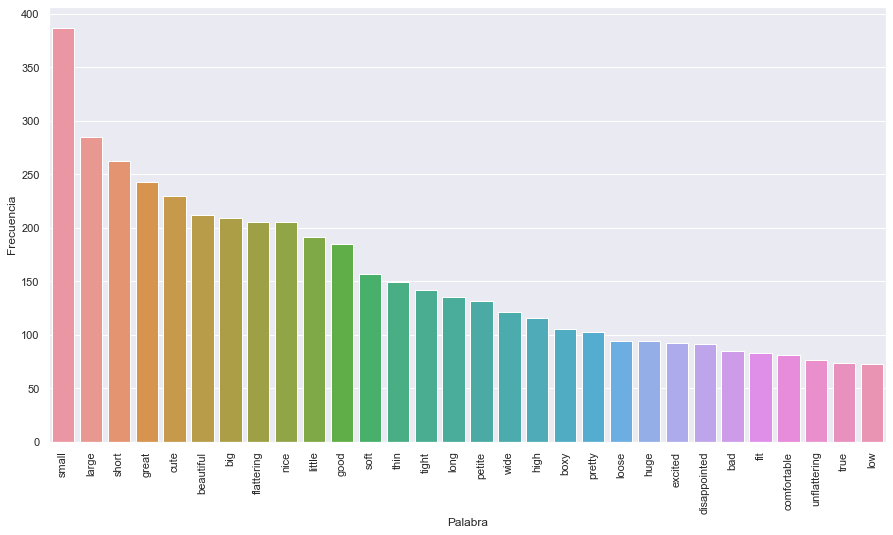

In [95]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_3_not_recom.iloc[:30].Palabra, y = df_rev_frec_3_not_recom.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

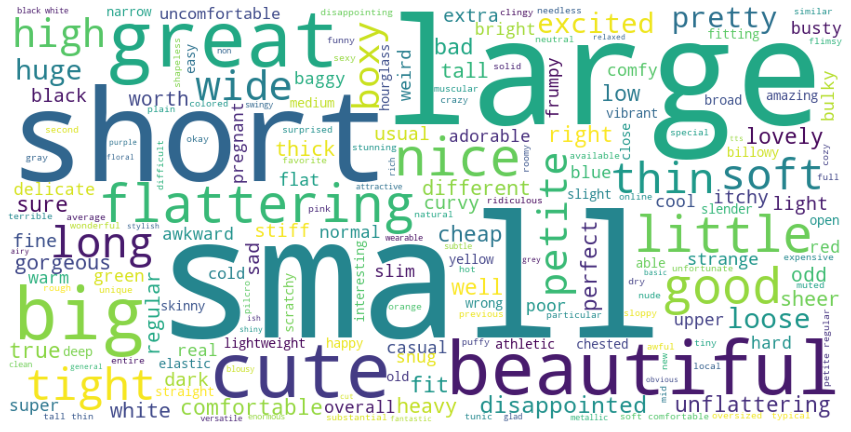

In [96]:
ver_wordcloud(reviews_3_not_recom)

*Hay una mezcla bastante pareja de las 2. Requerirá el análisis de otros factores.*

#### 13. ¿Hay reseñas de valoración alta (4-5) que no hayan recomendado la prenda? ¿Y valoraciones bajas (1-2) que sí recomienden?

In [97]:
df_12 = data[(data.rating <= 2)]
print('Cantidad de reseñas con baja valoración (1-2) que recomendaron el producto:',df_12[df_12.recommended == 1].shape[0])

Cantidad de reseñas con baja valoración (1-2) que recomendaron el producto: 109


In [98]:
df_45 = data[(data.rating >= 4)]
print('Reseñas con alta valoración (4-5) que no recomendaron el producto:',df_45[df_45.recommended == 0].shape[0])

Reseñas con alta valoración (4-5) que no recomendaron el producto: 187


In [99]:
df_3 = data[(data.rating == 3)]
print('Reseñas con valoración=3 que no recomendaron el producto:',df_3[df_3.recommended == 0].shape[0])
print('Reseñas con valoración=3 que recomendaron el producto:',df_3[df_3.recommended == 1].shape[0])

Reseñas con valoración=3 que no recomendaron el producto: 1653
Reseñas con valoración=3 que recomendaron el producto: 1170


In [100]:
# Liberamos espacio de memoria
del(data_grouped)
del(data_recom)
del(data_not_recom)
del(todas_reviews_not_recom)
del(reviews_3_not_recom)
del(todas_reviews_recom)
del(df_rev_frec_recom)
del(df_rev_frec_not_recom)
del(df_rev_frec_3_not_recom)
del(df)
gc.collect()

21675

### Trabajo con bigramas
En la parte de investigación del proyecto 3, se trató el tema del análisis de bigramas para evaluar si mejoraba el desempeño de los modelos predictivos, ya que se analiza una palabra junto con su contexto. Esot puede brindar más información a la hora de decidir a qué clase pertenece una reseña.

In [101]:
def listar_sust_adj(phrase):
    '''
    Función para generar bigramas por oración delimitada por puntos. 
    Considera ADJ/ADV + SUST/VERB que sean de más de 3 caracteres.
    
    Recibe una string y devuelve un listado de strings.
    '''
    sents = nltk.sent_tokenize(phrase.lower())
    adj_list = []
    sust_list = []
    sust_adj_list = []

    for oracion in sents:
        #print(oracion)
        doc = nlp(oracion) # create spacy object
        adj_list = []
        sust_list = []
        for item in doc:
            if (item.pos_ == "ADJ" or item.pos_ == "ADV") and len(item)>3: # separate nouns and not nouns
                adj_list.append(item.text)
            elif (item.pos_ == "NOUN" or item.pos_ == "VERB") and len(item)>3:
                sust_list.append(item.text)
        if(len(adj_list)!=0):
            for adj in adj_list:
                if(len(sust_list)!=0):
                    for sust in sust_list:
                        sust_adj_list.append(sust + " " + adj)
                else:
                    sust_adj_list.append(adj)
        elif(len(sust_list)!=0):
            for sust in sust_list:
                sust_adj_list.append(sust) 

    return sust_adj_list

In [103]:
# Miramos una clase de prenda al azar
rand_idx = np.random.randint(1,data.shape[0])
item = data.clothing_id.iloc[rand_idx]
item_data = data[data.clothing_id == item]
print("Tipo de la prenda:",  data.class_name.iloc[rand_idx])
print("Cantidad de reseñas de la prenda" + color.BOLD, item,color.END + ":", len(item_data))
print("Promedio de rating que ha recibido:" + color.YELLOW, item_data.rating.mean(),color.END)
item_data[['clothing_id','class_name','review_title','review_body','rating']].reset_index(drop = True, inplace=True)

Tipo de la prenda: Fine gauge
Cantidad de reseñas de la prenda 904 : 10
Promedio de rating que ha recibido: 3.7 


In [104]:
# miramos una reseña al azar dentro de la clase
rand_idx_item = np.random.randint(0,item_data.shape[0])
print(color.BOLD + "Título:" + color.END,item_data.review_title.iloc[rand_idx_item])
print(color.BOLD + "Reseña:" + color.END,item_data.review_body.iloc[rand_idx_item])
print(color.BOLD + "Rating:" + color.END,item_data.rating.iloc[rand_idx_item])
if (item_data.recommended.iloc[rand_idx_item]):
    print(color.BOLD + "Categoría:" + color.END + "Recomendado")
else:
    print(color.BOLD + "Categoría:" + color.END + "No recomendado")

Título: Beautiful fabric and detailing
Reseña: It's rare to find clothing made of quality fabrics, and this is a fine, soft wool blend. the design is feminine without being over-the-top, and the fit is slightly loose, as pictured on the model. i would not recommend wearing it with a belt, as pictured; it makes it look too "trendy" and detracts from the shape of the cardigan, which is beautiful on its own just skimming the body. it is a perfect topper and can work for daytime or an evening out. really lovely, and one of the few things i decid
Rating: 5
Categoría:Recomendado


In [105]:
listar_sust_adj(item_data.review_title.iloc[rand_idx_item] +' '+item_data.review_body.iloc[rand_idx_item])

['fabric beautiful',
 'detailing beautiful',
 'find beautiful',
 'clothing beautiful',
 'made beautiful',
 'quality beautiful',
 'fabrics beautiful',
 'wool beautiful',
 'blend beautiful',
 'fabric rare',
 'detailing rare',
 'find rare',
 'clothing rare',
 'made rare',
 'quality rare',
 'fabrics rare',
 'wool rare',
 'blend rare',
 'fabric fine',
 'detailing fine',
 'find fine',
 'clothing fine',
 'made fine',
 'quality fine',
 'fabrics fine',
 'wool fine',
 'blend fine',
 'fabric soft',
 'detailing soft',
 'find soft',
 'clothing soft',
 'made soft',
 'quality soft',
 'fabrics soft',
 'wool soft',
 'blend soft',
 'design feminine',
 'being feminine',
 'pictured feminine',
 'model feminine',
 'design slightly',
 'being slightly',
 'pictured slightly',
 'model slightly',
 'design loose',
 'being loose',
 'pictured loose',
 'model loose',
 'recommend trendy',
 'wearing trendy',
 'belt trendy',
 'pictured trendy',
 'makes trendy',
 'look trendy',
 'detracts trendy',
 'shape trendy',
 'car

## Preprocesamiento
### Importamos el dataset de entrenamiento
Importamos dataset que será utilizado para *train* y nos quedamos con las columnas relevantes.

<span style='color:red;'>**!! ACLARACIÓN:** En el notebook de <a href='https://github.com/lusalmeron/Acamica-DS-Proyecto-4/blob/main/Procesamiento_de_datasets.ipynb'>"Procesamiento_de_datasets"</a> se muestra el trabajo realizado para llegar a un único dataset filtrado por las columnas relevantes y que contengan también las lemmatizaciones y stemmizaciones de cada review concatenada a su título. **Ése es el set de datos que importamos para ahorrar tiempo de ejecución.**</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Garbage collector para optimizar recursos
import gc
# Clase para personalizar las impresiones de consola
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
import spacy # https://spacy.io/usage/models
nlp = spacy.load('en_core_web_md')

#Stop Words de en_core_news_md
from spacy.lang.en.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

import nltk

#Stop Words de nltk
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('english'))

# Para manejo de resgitros de texto
import re
from nltk.tokenize import RegexpTokenizer

#Constante de signos de puntuación
import string
puntua = string.punctuation + '#...'
excluded_pos = ['SCONJ','CCONJ','NUM','PUNCT','PRON','DET','ADP','AUX','X','PROPN']

In [3]:
# Importamos dataset limpio
data = pd.read_csv("data/dataset_clothes_clean.csv")
print("- Cantidad de filas " + color.BOLD + "total" + color.END + " del set:", data.shape[0])
print("- Cantidad de filas " + color.BOLD + "nulas" + color.END + " por columna:")
data.isna().sum()

- Cantidad de filas total del set: 22628
- Cantidad de filas nulas por columna:


class_name      0
clothing_id     0
usr_age         0
review_title    0
review_body     0
rating          0
recommended     0
revs_lemma      0
revs_stem       0
dtype: int64

In [107]:
data.sample(5)

,class_name,clothing_id,usr_age,review_title,review_body,rating,recommended,revs_lemma,revs_stem
17800,Lounge,440,49,The coolest pants,"When i tried them on, i didn't want to take th...",5,1,cool pant when try want soft stylish drape bod...,coolest pant when tri want soft stylish drape ...
3743,Dresses,1081,55,Perfect dress for a civil ceremony!,This dress is gorgeous. i purchased it recentl...,5,1,perfect dress civil ceremony dress gorgeous pu...,perfect dress civil ceremoni dress gorgeou pur...
13429,Skirts,1016,36,"Really great, might be for taller gals",Really cute skirt. found it to be too much mat...,5,1,really great tall gal really cute skirt find m...,realli great taller gal realli cute skirt foun...
18722,Blouses,835,46,Super cute!,Love this top- great for summer- unique in the...,4,1,super cute love top- great unique print feel g...,super cute love top- great uniqu print feel gr...
12173,Dresses,1081,30,-,"I wasn't sure how this dress would be sized, s...",4,1,sure dress size order different size keep smal...,sure dress size order differ size kept smaller...


### Tokenización 
Si bien el dataset ya está limpio, tomamos una review al azar y aplicamos funciones y objetos de la librería spaCy para explorarlos.

In [6]:
# Miramos una review al azar
random_index = np.random.randint(0,data.shape[0])
review = data.review_body.iloc[random_index]
title = data.review_title.iloc[random_index]
print(color.BOLD + '- ID:' + color.END, random_index,'\n' + color.BOLD + '- Título:' + color.END,title,'\n' + color.BOLD + '- Reseña:' + color.END, review)
print(color.BOLD + '- Valoración:' + color.END,data.rating[random_index])
if (data.recommended.iloc[random_index]):
    print(color.BOLD + "- Clase: " + color.END + "Recomendado")
else:
    print(color.BOLD + "- Clase: " + color.END + "No recomendado")
print(color.BOLD + '- Categoría:' + color.END, data.class_name[random_index])

- ID: 14504 
- Título: Pretty, but buttons stand out too much. 
- Reseña: I like this coat, especially the collar and cuffs. but the buttons were too eye-catching for me. i wanted something more subtle. still, i recommend the coat.
- Valoración: 4
- Clase: Recomendado
- Categoría: Sweaters


In [7]:
# Mostramos las POS de la review elegida
sent = nlp(review)
print("{0:20}{1:20}".format("PALABRA:","POS:"))
for token in sent:
    print("{0:20}{1:20}".format(token.text,token.pos_))

PALABRA:            POS:                
I                   PRON                
like                VERB                
this                DET                 
coat                NOUN                
,                   PUNCT               
especially          ADV                 
the                 DET                 
collar              NOUN                
and                 CCONJ               
cuffs               NOUN                
.                   PUNCT               
but                 CCONJ               
the                 DET                 
buttons             NOUN                
were                AUX                 
too                 ADV                 
eye                 NOUN                
-                   PUNCT               
catching            VERB                
for                 ADP                 
me                  PRON                
.                   PUNCT               
i                   PRON                
wanted          

In [8]:
# Visualización de los POS
from spacy import displacy
displacy.render(sent, style="dep")

### Lemmatizer
Analizamos esta función de la librería spaCy con la review al azar.

In [9]:
# Tokens lemmatizados de la review elegida
print("{0:20}{1:20}{2:20}".format("PALABRA:","POS:","LEMMA:"))
for token in sent:
    print("{0:20}{1:20}{2:20}".format(token.text,token.pos_,token.lemma_))

PALABRA:            POS:                LEMMA:              
I                   PRON                I                   
like                VERB                like                
this                DET                 this                
coat                NOUN                coat                
,                   PUNCT               ,                   
especially          ADV                 especially          
the                 DET                 the                 
collar              NOUN                collar              
and                 CCONJ               and                 
cuffs               NOUN                cuff                
.                   PUNCT               .                   
but                 CCONJ               but                 
the                 DET                 the                 
buttons             NOUN                button              
were                AUX                 be                  
too                 ADV 

In [112]:
#Función para limpieza de datos con lemmatizer
def text_data_lemma(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy and len(token.text)>2): 
            temp = token.lemma_.strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

In [113]:
# Lemmatizamos y filtramos la review escogida
print(color.BOLD + "[ REVIEW ORIGINAL ] :" + color.END, review)
clean_review = text_data_lemma(review)
clean_review = " ".join(clean_review)
print(color.BOLD + "\n[ REVIEW LEMMATIZADA ] :" + color.END, clean_review)

[ REVIEW ORIGINAL ] : This sweater i bought to go with a navy dress. it is not ivory. it is sortof a blush color???? not at all what i had in mind. the sweater itself is pretty. the back is shorter as someone else described which looks slightly awkward when wearing it. definite return. :(

[ REVIEW LEMMATIZADA ] : sweater buy navy dress ivory sortof blush color mind sweater pretty short describe look slightly awkward wear definite return


### Stemmizer
Analizamos esta función de la librería spaCy con la review al azar.

In [114]:
# Importamos objeto de nltk que nos permite stemmizar en español
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [115]:
# Porbamos el stemmer en review al azar
sent = nlp(review)
print("{0:20}{1:20}{2:20}".format("PALABRA:","POS:","STEM:"))
for token in sent:
    print("{0:20}{1:20}{2:20}".format(token.text,token.pos_,stemmer.stem(token.text)))

PALABRA:            POS:                STEM:               
This                DET                 thi                 
sweater             NOUN                sweater             
i                   PRON                i                   
bought              VERB                bought              
to                  PART                to                  
go                  VERB                go                  
with                ADP                 with                
a                   DET                 a                   
navy                NOUN                navi                
dress               NOUN                dress               
.                   PUNCT               .                   
it                  PRON                it                  
is                  AUX                 is                  
not                 PART                not                 
ivory               ADJ                 ivori               
.                   PUNC

In [116]:
# Función para limpieza de datos con stemmer
def text_data_stem(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy and len(token.text)>2): 
            temp = stemmer.stem(token.text).strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

In [117]:
# Filtramos y stemmizamos la review escogida
print(color.BOLD + "[ REVIEW ORIGINAL ] :" + color.END, review)
clean_review = text_data_stem(review)
clean_review = " ".join(clean_review)
print(color.BOLD + "\n[ REVIEW STEMMIZADA ] :" + color.END, clean_review)

[ REVIEW ORIGINAL ] : This sweater i bought to go with a navy dress. it is not ivory. it is sortof a blush color???? not at all what i had in mind. the sweater itself is pretty. the back is shorter as someone else described which looks slightly awkward when wearing it. definite return. :(

[ REVIEW STEMMIZADA ] : sweater bought navi dress ivori sortof blush color mind sweater pretti shorter describ look slightli awkward wear definit return


In [118]:
gc.collect()

192

<span style='color:blue;'> En el documento [Comparacion_lemma_stem.pdf](https://github.com/lusalmeron/Acamica-DS-Proyecto-4/blob/main/Comparacion_lemma_stem.pdf) se encuentra el análisis de los distintos modelos y vectorizadores con variados valores de hiperparámetros y los datasets lemmatizados y stemmizados. En la conclusión se explica que el modelo de mejor desempeño es el **SVM con monogramas lematizados**, por eso dejamos aquí los valores de la conclusión.</span>

Para ver los demás modelos, revisar el Notebook de [Evaluación de modelos](https://github.com/lusalmeron/Acamica-DS-Proyecto-4/blob/main/Evaluacion%20de%20modelos.ipynb).

## Vectorización

### Importar y crear vectorizador

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features=10000 # Determina máximo de palabras que toma para hacer la matriz
min_df = 0.0001 # Toma todas las palabras que tengan este mínimo de frecuencia
ngram_range = (1,1)

tfidf = TfidfVectorizer(max_features=max_features, min_df=min_df,ngram_range=ngram_range)

### Separamos datasets lemma y stem

In [16]:
# Columnas de interés del dataset LEMMA
data.loc[:,('class_name','usr_age','revs_lemma','rating','recommended')].head()

,class_name,usr_age,revs_lemma,rating,recommended
0,Intimates,33,absolutely wonderful silky sexy comfortable,4,1
1,Dresses,34,love dress sooo pretty happen find store glad ...,5,1
2,Dresses,60,major design flaw high hope dress want work in...,3,0
3,Pants,50,favorite buy love love love jumpsuit fun flirt...,5,1
4,Blouses,47,flattering shirt shirt flattering adjustable t...,5,1


En primera instancia, entrenamos el modelo con sólo las reseñas, pero podría probarse agregar otros atributos si mejora el desempeño.

In [5]:
## LEMMA
list_revs = list(data[('revs_lemma')].values)
recom = data['recommended'].values

list_revs[:5]

['absolutely wonderful silky sexy comfortable',
 'love dress sooo pretty happen find store glad order online petite buy petite love length me- hit little knee definitely true midi truly petite',
 'major design flaw high hope dress want work initially order petite small usual size find outrageously small small fact zip reorder petite medium overall half comfortable fit nicely half tight layer somewhat cheap net layer imo major design flaw net layer sew directly zipper',
 'favorite buy love love love jumpsuit fun flirty fabulous time wear great compliment',
 'flattering shirt shirt flattering adjustable tie perfect length wear legging sleeveless pair cardigan love shirt']

### Train-Test split de los datos
Usaremos el 70% para entrenamiento y el 30% para prueba. Luego vectorizaremos cada set por separado para evitar *data leaks*.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(list_revs,recom,test_size=0.3,random_state=42,stratify=recom)
print("- Tamaño del set de " + color.CYAN + "entrenamiento:" + color.BOLD, len(X_train), color.END)
print("- Tamaño del set de " + color.GREEN + "prueba:" + color.BOLD, len(X_test),color.END)
print("- Algunos " + color.BOLD + "ejemplos" + color.END + " del set de entrenamiento:")
X_train[:5]

- Tamaño del set de entrenamiento: 15839 
- Tamaño del set de prueba: 6789 
- Algunos ejemplos del set de entrenamiento:


['love unusual print cut work get round sway dress look twice big actually shaping help adjust curve sad',
 'love love love dress absolutely layered cloud material amazingly soft comfy',
 'fit perfect sleeve little tight uncomfortably wish little room look picture love shirt super cute comfy get compliment',
 'comfy cute grab pair pant sale glad material soft lightweight-- ideal summer fit loose true size standard pair pant',
 'gorgeous comfy barely rarely find maxi far long extreme prefer barely reach ground oppose rise inch floor example perfect flat sandal try chuckle long try perfect length bodice fit glove average bust size fluctuate generally flat chested prefer conservative sleeveless dress']

### Generación de la matriz

In [7]:
# Ajustamos el vectorizador y transformamos los datos de entrenamiento
matriz_train = tfidf.fit_transform(X_train)
matriz_train

<15839x5245 sparse matrix of type '<class 'numpy.float64'>'
	with 354308 stored elements in Compressed Sparse Row format>

In [8]:
# Vemos las palabras utilizadas (ordenadas alfabéticamente)
all_words = tfidf.get_feature_names()
print("Palabras más usadas:",all_words[:200])

Palabras más usadas: ['00p', '10', '10p', '10th', '12', '12p', '130', '138', '140', '145', '155lb', '16', '1960', '1980', '1st', '20', '20th', '24p', '25', '25p', '26', '27', '27p', '28', '29', '29p', '2nd', '30', '30d', '30dd', '30f', '32', '32a', '32b', '32c', '32d', '32dd', '32ddd', '32e', '32f', '33', '34', '34a', '34aa', '34b', '34c', '34d', '34dd', '34ddd', '34f', '35', '36a', '36b', '36c', '36d', '36dd', '36ddd', '37ish', '38', '38c', '38d', '3rd', '40', '40d', '40th', '4th', '50', '50th', '5ft2', '5th', '60', '60th', '6th', '70', '80', '90', '95lb', 'ab', 'abdomen', 'ability', 'able', 'abo', 'abroad', 'abso', 'absolute', 'absolutely', 'absolutly', 'abstract', 'absurd', 'abt', 'abundance', 'accent', 'accentuate', 'accept', 'acceptable', 'access', 'accessorize', 'accessorizing', 'accessory', 'accident', 'accidental', 'accidentally', 'accommodate', 'accomodate', 'accomplish', 'accord', 'accordingly', 'account', 'accurate', 'accurately', 'achieve', 'ack', 'acrylic', 'act', 'active'

In [9]:
# Transformamos los datos de prueba en base al vectorizador ya entrenado
matriz_test = tfidf.transform(X_test)
matriz_test

<6789x5245 sparse matrix of type '<class 'numpy.float64'>'
	with 150894 stored elements in Compressed Sparse Row format>

## Modelización

In [10]:
# Importamos modelos
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [11]:
xtrain = matriz_train.toarray()
xtest = matriz_test.toarray()

# Para la validación cruzada neceitamos el set entero
X = tfidf.transform(list_revs)
X = X.toarray()
y = recom
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Métricas de evluación

In [12]:
from sklearn.metrics import classification_report # Para un reporte con precision, recall y f1_score
from sklearn.metrics import accuracy_score

Vamos a utilizar el **accuracy score** para evaluar en general la precisión del multiclasificador, ya que genera un promedio entre todas las clases (que en nuestro dataset están balancedas en cantidad) y hace un ajuste entre *precisión* y *recall*. 

Como complemento, utilizaremos el **Calssification report** para ver cómo varían la precisión y el recall por clase.

También elaboramos función para visualizar la **matriz de confusión** de cada modelo.

In [13]:
from sklearn.metrics import confusion_matrix

def confusion(ytest,y_pred):
    names=["No Recomendado","Recomendado"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Validación cruzada

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def k_validacion_cruzada(model,x,y,k):
    scores = cross_val_score(model, x, y, cv=k)
    print("%0.2f de precisión con desviación estándar de %0.2f" % (scores.mean(), scores.std()))

### SVM

In [140]:
# En vez de utilizar SVC, vamos a usar LinearSVC, 
# ya que para el Kernel Lineal esta función es MUCHO mas rapida que la tradicional SVC.

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)

y_pred = svc.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END, accuracy_score(ytest, y_pred))

Accuracy :  0.9019001325673884


In [141]:
print(color.BOLD + 'Validación cruzada:' + color.END)
k_validacion_cruzada(svc,X,recom,5)

Validación cruzada:
0.90 de precisión con desviación estándar de 0.00


In [142]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['No Rec','Rec']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

      No Rec       0.77      0.65      0.71      1230
         Rec       0.93      0.96      0.94      5559

    accuracy                           0.90      6789
   macro avg       0.85      0.80      0.82      6789
weighted avg       0.90      0.90      0.90      6789



*Las métricas del reporte se ven explicadas en la matriz de confusión.*

Matriz de confusión : 


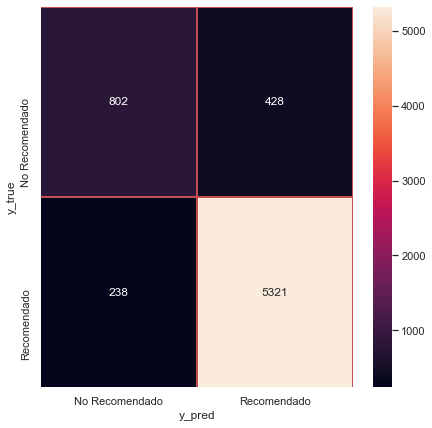

In [143]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

## Optimización de hiperparámetros del SVC
Para encontrar los valores que maximizan el rendimiento del modelo, vamos a realizar la optimización tanto del SVC como del Vectorizador, ya que las palabras utilizadas para la clasificación influyen en el desempeño del modelo.

Para el vectorizador utilizaremos la **estartegia manual** para encontrar el mínimo valor de frecuencia de palabras (`min_df`) que filtre a las que serán utilizadas para la vectorización.

En cambio, para optimizar el modelo utilizaremos **Grid Search** y encontraremos los valores de `C` que maximicen su accuracy.

### Búsqueda manual
#### Vectorizer

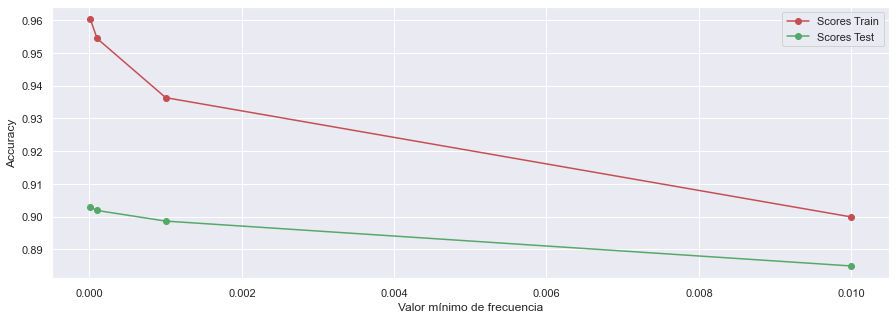

In [183]:
scores_train = []
scores_test = []
max_features = 10000
list_min_df = [0.00001,0.0001,0.001,0.01]
svc = LinearSVC(C = 1)

for value in list_min_df:
    tfidfop = TfidfVectorizer(max_features=max_features, min_df=value)
    mxtrain = tfidfop.fit_transform(X_train)
    mxtest = tfidfop.transform(X_test)
    
    xtrain = mxtrain.toarray()
    xtest = mxtest.toarray()
    
    svc.fit(xtrain,ytrain)
    
    y_pred_train = svc.predict(xtrain)
    y_pred_test = svc.predict(xtest)
    
    scores_train.append(accuracy_score(ytrain, y_pred_train))
    scores_test.append(accuracy_score(ytest, y_pred_test))

scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

plt.figure(figsize=(15,5))
plt.plot(list_min_df,scores_train,'o-', label = 'Scores Train', c='r')
plt.plot(list_min_df,scores_test,'o-', label = 'Scores Test', c='g')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Valor mínimo de frecuencia')
plt.show()

Hacemos zoom en la zona de los valores más altos.

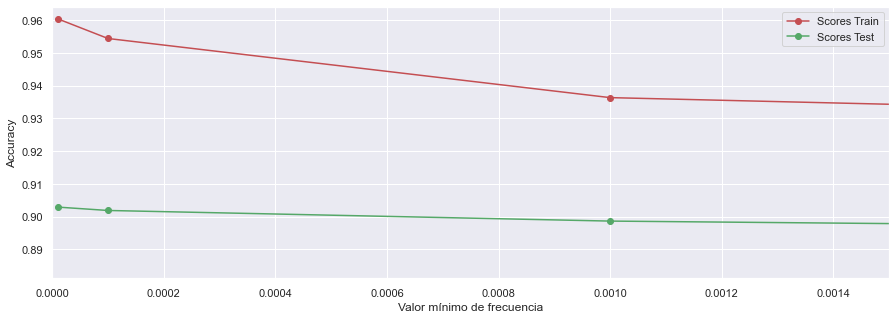

In [184]:
#cte = np.ones(max(scores_train))
plt.figure(figsize=(15,5))
plt.plot(list_min_df,scores_train,'o-', label = 'Scores Train', c='r')
plt.plot(list_min_df,scores_test,'o-', label = 'Scores Test', c='g')
#plt.plot(0.001, ls = '--', lw = 2, c='r',label = 'Valoración media')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Valor mínimo de frecuencia')
plt.xlim(0,0.0015)
plt.show()

Haciendo *zoom* en la zona que tiene mayor accuracy en el conjunto de test vemos que fue obtenido con el valor `min_df = 0.00001`. Además, es el que menos separado está del accuracy del conjunto de train. Por tanto, éste es el valor óptimo.

In [185]:
print(f"El accuracy para min_df={list_min_df[0]} es " + color.BOLD + f"{scores_test[0]}" + color.END)

El accuracy para min_df=1e-05 es 0.9029312122551185


Ahora pasamos a optimizar los hiperparámetros del modelo SVC Lineal utilizando el método de Grid Search.

In [186]:
del(mxtrain)
del(mxtest)
del(xtrain)
del(xtest)
del(y_pred_train)
del(y_pred_test)
gc.collect()

28567

### Grid Search
#### Optimización del modelo SVC

In [23]:
# Grilla para Grid Search
param_grid = {'C':[0.1,0.2,0.3,0.4,0.5]}

# Grid Search
from sklearn.model_selection import GridSearchCV
svcgs = LinearSVC()
model = GridSearchCV(svcgs, param_grid=param_grid)

In [24]:
# Vectorizador optimizado
max_features=10000
min_df=0.00001
tfidfop = TfidfVectorizer(max_features=max_features, min_df=min_df)
mxtrain = tfidfop.fit_transform(X_train)
mxtest = tfidfop.transform(X_test)

xtrain = mxtrain.toarray()
xtest = mxtest.toarray()
mxtrain

<15839x9491 sparse matrix of type '<class 'numpy.float64'>'
	with 358554 stored elements in Compressed Sparse Row format>

In [25]:
# Entrenamiento
model.fit(xtrain, ytrain)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5]})

In [26]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores parametros: {'C': 0.3}
Mejor Score: 0.9011301043271361



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.230457,0.093982,0.047954,0.000662,0.1,{'C': 0.1},0.890783,0.893939,0.903409,0.897096,0.894537,0.895953,0.004235,5
1,1.200373,0.008695,0.048354,0.001044,0.2,{'C': 0.2},0.894886,0.896780,0.906250,0.904356,0.899274,0.900309,0.004350,4
2,1.197916,0.007885,0.049166,0.000754,0.3,{'C': 0.3},0.894571,0.898043,0.906566,0.905619,0.900853,0.901130,0.004524,1
3,1.208416,0.006417,0.047776,0.000399,0.4,{'C': 0.4},0.892992,0.898674,0.906250,0.904672,0.899274,0.900372,0.004724,3
4,1.211087,0.010571,0.048551,0.001055,0.5,{'C': 0.5},0.893624,0.898043,0.905934,0.906250,0.899905,0.900751,0.004816,2


### Evaluación del modelo optimizado
Los datos se vectorizan con el tfidf con un `mìn_df = 0.00001` y `max_features = 10000`.<br>
Luego se entrena un modelo `LinearSVC`con `C = 0.3`.

In [27]:
max_features=10000
min_df=0.00001
tfidfop = TfidfVectorizer(max_features=max_features, min_df=min_df)
mxtrain = tfidfop.fit_transform(X_train)
mxtest = tfidfop.transform(X_test)

xtrain = mxtrain.toarray()
xtest = mxtest.toarray()

C=0.3
svcop = LinearSVC(C=C)
svcop.fit(xtrain,ytrain)

y_pred = svcop.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END + color.YELLOW, accuracy_score(ytest, y_pred), color.END)

Accuracy :  0.9017528354691413 


In [28]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['No recomendado','Recomendado']))

Reporte de clasificación : 
 
                 precision    recall  f1-score   support

No recomendado       0.80      0.61      0.69      1230
   Recomendado       0.92      0.97      0.94      5559

      accuracy                           0.90      6789
     macro avg       0.86      0.79      0.82      6789
  weighted avg       0.90      0.90      0.90      6789



Matriz de confusión : 


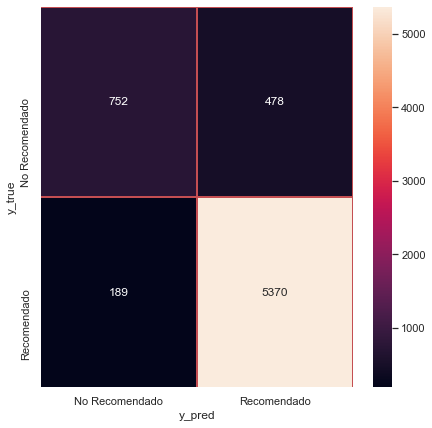

In [29]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

## Conclusión de la optimización --> Falta
Lo mejor que se pudo obtener con los hiperparámetros óptimos establecidos es una **precisión del 90,17%**.
No representa una significativa variación con el modelo base utilizado para el entrenamiento, lo que significa que ya era suficientemente efectivo.

Como vemos en la matriz de confusión, los más fáciles de identificar son las reviews que terminan en recomendación y la más conflictiva es la clase no recomendada, que el **máximo recall** que se pudo lograr es del **61%**.

De todas formas, se podría confiar en que el modelo es útil para identificar aquellos compradores que es más probable que recomienden el producto para plantear estrategias de marketing.

In [18]:
# Liberamos espacio en memoria
del(data)
gc.collect()

43

# Futuras líneas de investigación
Para aumentar el rendimiento del modelo, me gustaría a futuro:

1. Utilizar alguna **máquina virtual** en la nube para tener más potencia a la hora de ntrenar u optimizar modelos. En mi computadora con mucho esfuerzo lograron correr los que están en este notebook.
1. Poder **involucrar las categorías de los productos** para entrenar los modelos, ya que puede haber palabras que tengan más relevancia en una categoría que en otras. Esto implicaría a su vez matrices con más dimensiones en el entrenamiento, complejizándose el procedimiento.
1. Explorar **pipelines de trabajo** para automatizar los procesos vectorización y entrenamiento. Por las características de la PC que estoy utilizando no me fue podible realizar esto ya que consumía demasiados recursos. Pero con alguna tecnología en la nube o una mejor máquina podría implementarse.
1. Utilizar una **Red Neuronal Artificial** y evaluar su desempeño, ya que puede ser más precisa a la hora de distinguir la connotación negativa o positiva de las reseñas por sí misma.